### ***Initializing and Importing Packages***

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import networkit as nk 
import networkx as nx
from igraph import *
import seaborn as sns

sns.color_palette("Set2")
sns.set_theme()
# For the image quality of the graphic. 
sns.set(rc={"figure.dpi":250})
# For the size of the graphics
#sns.set(rc = {"figure.figsize":(4,2)})
sns.set(font_scale = 0.5)

DataDir = "../../Data/"
FigsDir = "../../Figs/"

symboles = [ 'ADA', 'BTC', 'ETH', 'SOL', 'XRP']


### ***Prepairing the Data*** 

In [2]:
symboles = [ 'ADA', 'BTC', 'ETH', 'SOL', 'XRP']
for sym in symboles:
    df_read = pd.read_csv(DataDir + "Stage-4-Data/%s.csv" % sym)
    data = df_read["time_period_start;time_period_end;time_open;time_close;rate_open;rate_high;rate_low;rate_close"].str.split(";", expand=True)
    data.rename(columns={0: 'time_period_start', 1: 'time_period_end', 2: 'time_open', 3: 'time_close',
        4: 'rate_open', 5: 'rate_high', 6: 'rate_low', 7: 'rate_close'}, inplace=True)
    data.to_csv(DataDir + 'Stage-7-Data/%s.csv' % sym , index=False)

#### ***Constructing the Returns' Dataframe*** 

In [3]:
df_t_read = pd.read_csv(DataDir + "Stage-7-Data/%s.csv" % symboles[1])
returns_df = pd.DataFrame()
returns_df['time_close'] = pd.to_datetime(df_t_read['time_close'], dayfirst= True)
for sym in symboles:
    df_read = pd.read_csv(DataDir + "Stage-7-Data/%s.csv" % sym)
    returns_df['%s' % sym] = df_read.rate_close.pct_change(1).mul(100)
    
returns_df = returns_df.iloc[1:]
returns_df.fillna('ffill')
    

,time_close,ADA,BTC,ETH,SOL,XRP
1,2022-01-31 00:09:00+00:00,-0.567315,-0.339329,-0.429146,-0.706729,-0.593215
2,2022-01-31 00:14:00+00:00,-0.051631,-0.079033,-0.222207,-0.117073,-0.048158
3,2022-01-31 00:19:00+00:00,-0.008450,-0.065205,-0.087114,-0.021099,0.043504
4,2022-01-31 00:24:00+00:00,-0.174753,-0.129413,-0.101416,0.016644,-0.078449
5,2022-01-31 00:29:00+00:00,0.076977,-0.024823,-0.012987,0.077142,-0.072341
...,...,...,...,...,...,...
1148,2022-02-03 23:44:00+00:00,0.083392,0.147659,0.200445,0.387029,0.057171
1149,2022-02-03 23:49:00+00:00,0.314611,0.169400,0.279939,0.380504,0.133535
1150,2022-02-03 23:54:00+00:00,-0.330443,-0.203505,-0.239980,-0.386303,-0.092905
1151,2022-02-03 23:59:00+00:00,0.703719,0.629325,0.845698,1.083700,0.540392


In [30]:
plt.style.use('seaborn-pastel')

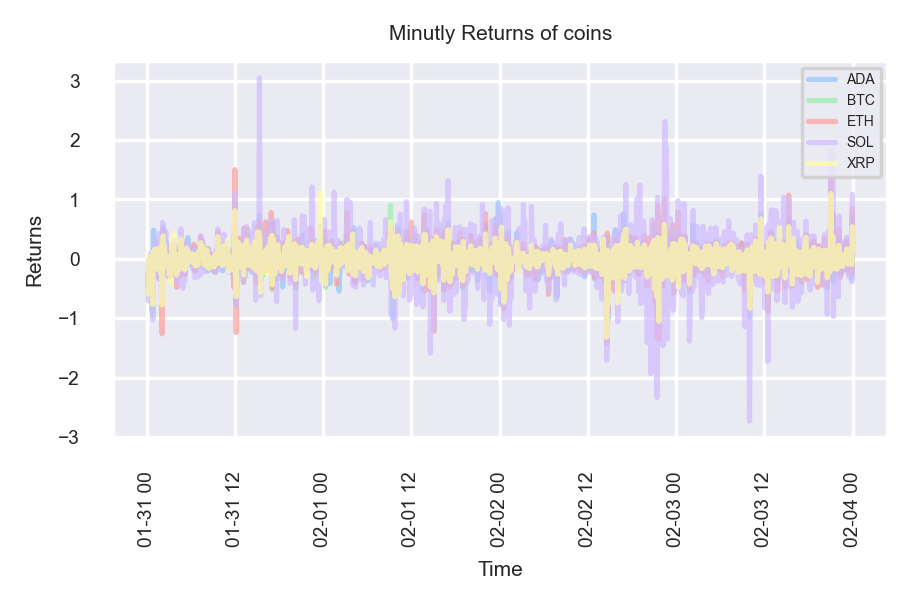

In [31]:
for sym in symboles:
    plt.plot(returns_df['time_close'], returns_df['%s' % sym], label = '%s' % sym, alpha = 0.7)

plt.title('Minutly Returns of coins')
plt.xlabel('Time')
plt.xticks(rotation=90)
plt.ylabel('Returns')
plt.legend(loc=1, prop={'size': 4})
plt.show()
#plt.savefig('Minutly Returns of coins.pdf')

### ***The Eddy-Fuller test***

In [6]:
for sym in symboles:
    result = sts.adfuller(returns_df['%s' % sym])
    print('p-value (%s) = %s ' % (sym , result[1]) )


p-value (ADA) = 6.478327163602919e-30 
p-value (BTC) = 2.027917833467083e-30 
p-value (ETH) = 0.0 
p-value (SOL) = 0.0 
p-value (XRP) = 0.0 


### ***Optimum Lag***

In [7]:
var_model = VAR(returns_df.iloc[:, 1:3])
x = var_model.select_order(maxlags=40)
x.summary()

,AIC,BIC,FPE,HQIC
0,-7.559,-7.550*,0.0005216,-7.555*
1,-7.559,-7.532,0.0005214,-7.549
2,-7.559,-7.514,0.0005212,-7.542
3,-7.561,-7.498,0.0005205,-7.537
4,-7.564*,-7.483,0.0005187*,-7.534
5,-7.563,-7.464,0.0005195,-7.525
6,-7.559,-7.441,0.0005216,-7.514
7,-7.561,-7.425,0.0005205,-7.509
8,-7.560,-7.407,0.0005209,-7.502
9,-7.557,-7.386,0.0005223,-7.492


### ***Granger-Cause Test***

In [8]:
maxlag = 4
test = 'ssr_chi2test'
test = 'ssr_ftest'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df_p = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    df_f = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df_p.columns:
        for r in df_p.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0]['ssr_chi2test'][0],4) for i in range(maxlag)]
            F_score = round(test_result[maxlag][0]['ssr_ftest'][0],4)            
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df_p.loc[r, c] = min_p_value
            df_f.loc[r, c] = F_score
    df_f.columns = [var + '_x' for var in variables]
    df_f.index = [var + '_y' for var in variables]      
    df_p.columns = [var + '_x' for var in variables]
    df_p.index = [var + '_y' for var in variables]
      
    return df_p, df_f

df_p, df_f = grangers_causation_matrix(returns_df.iloc[:, 1:], variables = returns_df.columns[1:])

In [9]:
df_p #the dataframe consisting the minimum p-values

,ADA_x,BTC_x,ETH_x,SOL_x,XRP_x
ADA_y,0.0000,2.2230,0.0134,2.9533,0.0738
BTC_y,1.2767,0.0000,3.3277,6.8843,5.8888
ETH_y,0.0054,1.1027,-0.0000,3.3920,1.5541
SOL_y,0.8949,5.5084,0.4820,-0.0000,2.6274
XRP_y,0.2216,5.9974,0.7577,3.1690,0.0000


In [10]:
df_f #the dataframe consisting of the f-scores for lag = 4

,ADA_x,BTC_x,ETH_x,SOL_x,XRP_x
ADA_y,0.0000,1.0954,0.9051,1.2617,0.1496
BTC_y,0.7462,0.0000,1.9240,2.0195,1.9373
ETH_y,1.1592,0.9390,-0.0000,1.2867,0.7963
SOL_y,2.0190,3.2705,1.1631,-0.0000,1.1003
XRP_y,0.4130,2.1360,1.0388,1.6284,0.0000


Text(0.5, 1.0, 'Heatmap plot for F-scores')

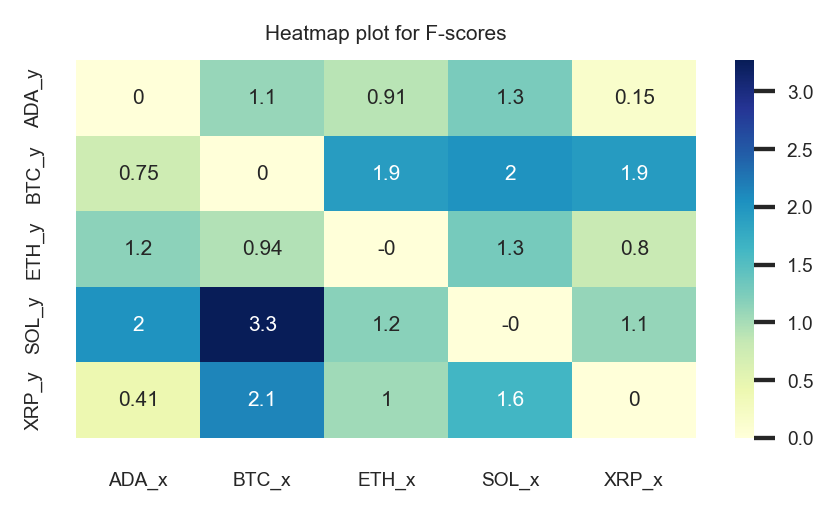

In [40]:
sns.heatmap(df_f, annot = True, cmap="YlGnBu")
plt.title('Heatmap plot for F-scores')

In [143]:
# def round_(matrix, threshold):
#     for i in range(len(matrix)):
#         for j in range(len(matrix)):
#             if matrix[i,j] > threshold:
#                 matrix[i,j] = 1.0
#             else:
#                 matrix[i,j] = 0.0
#     return matrix


In [149]:
# Mat = abs(np.array(df_f) - np.array(df_f).max())   
# Mat = (Mat - Mat.min()) / (Mat.max() - Mat.min())
# for i in range(5):
#     Mat[i,i] = 0.0
# Mat_ = round_(Mat, 0.5)

### ***Graph***

In [218]:
Mat = 1 - np.array(df_p)

for i in range(5):
    Mat[i,i] = 0.0

Mat = (Mat - Mat.min()) / (Mat.max() - Mat.min())
for i in range(len(Mat)):
    for j in range(len(Mat)):
        Mat[i,j] = round(Mat[i,j] , 1)


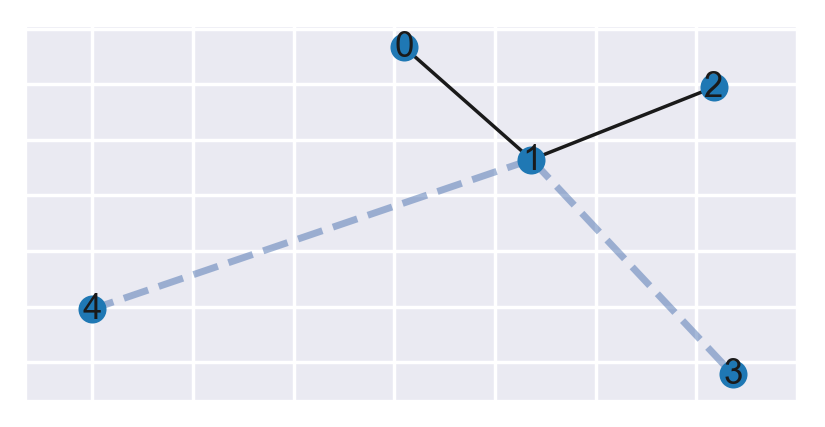

In [219]:
G_ = nx.from_numpy_array(Mat)

G=nx.minimum_spanning_tree(G_)
edge_labels = nx.get_edge_attributes(G, "weight")
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]
# nx.draw(T)
pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")
#nx.draw_networkx_edge_labels(G, pos, edge_labels)
# nx.draw_networkx_labels(T, labels = {})
nx.draw_networkx_nodes(G, pos, node_size=50)
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1)
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=2, alpha=0.5, edge_color="b", style="dashed")
